In [1]:
import os
import numpy as np
import random
import torch
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

# Reproducibility

In [3]:
# For code reproducibility

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(42)

# Load data

In [4]:
transform = transforms.Compose([transforms.ToTensor(), # automatically scales the input data to the range of [0,1]
                                transforms.Normalize((0.5,), (0.5,))]) # normalize with mean and standard deviation of the FashionMNIST training set

In [5]:
# Downloading Torchvision FashionMNIST dataset

trainset = FashionMNIST(root='FashionMNIST/train/',
                        train=True,
                        transform=transform, # (C,H,W), each pixel normalized to [0,1]
                        download=True)
testset = FashionMNIST(root='FashionMNIST/test/',
                       train=False,
                       transform=transform,
                       download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.3MB/s]


Extracting FashionMNIST/train/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/train/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 207kB/s]


Extracting FashionMNIST/train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/train/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.88MB/s]


Extracting FashionMNIST/train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/train/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.03MB/s]


Extracting FashionMNIST/train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/train/FashionMNIST/raw



100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]


Extracting FashionMNIST/test/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/test/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting FashionMNIST/test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/test/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]


Extracting FashionMNIST/test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/test/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 25.0MB/s]

Extracting FashionMNIST/test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/test/FashionMNIST/raw



In [6]:
print(f"# of train data: {len(trainset)}, # of test data: {len(testset)}")

# of train data: 60000, # of test data: 10000


In [7]:
# Splitting train/validation set

index = list(range(len(trainset)))
np.random.shuffle(index)
cutoff = int(len(index)*0.9)

train_idx = index[:cutoff] # 90%
val_idx = index[cutoff:] # 10%

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [8]:
# Generating train/val/test dataloader

train_loader = DataLoader(trainset, batch_size=64, sampler=train_sampler,
                          num_workers=2, shuffle=False, pin_memory=True)

val_loader = DataLoader(trainset, batch_size=64, sampler=val_sampler,
                        num_workers=2, shuffle=False, pin_memory=True)

test_loader = DataLoader(testset, batch_size=1,
                         num_workers=2, shuffle=False, pin_memory=True)

# Define basic CNN model

In [9]:
# Defining a CNN model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # 처음 input shape: [b, 1, 28, 28]

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), # (in_channels, out_channels, kernel_size, stride, padding)
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU()
        ) # [b, 16, 14, 14]

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU()
        )  # [b, 32, 7, 7]

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 16, 3, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )  # [b, 16, 4, 4]

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1)) # [b, 16, 1, 1]
        self.linear = nn.Linear(16, 10) # [b, 10]

    def forward(self, input):
        ret = self.conv1(input)
        ret = self.conv2(ret)
        ret = self.conv3(ret)
        ret = self.gap(ret).squeeze()
        ret = self.linear(ret)

        return ret

In [10]:
model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train & Validation

In [11]:
# hyperparameter setting

epochs = 32

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
best_acc = 0
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
os.makedirs('./weights', exist_ok=True)
dormant = 0

for epoch in range(epochs):
    avg_train_loss = AverageMeter()
    train_correct = 0
    train_total = 0

    # train
    model.train()
    for idx, i in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}"):
        data_x = i[0].type(torch.float32).to(device) # torch.tensor, [b, 1, 28, 28]
        data_y = i[1].type(torch.int64).to(device) # torch.tensor, [b]

        out = model(data_x) # torch.tensor, [b, 10]
        pred_y = torch.argmax(out, dim=1) # [b]

        train_total += data_y.shape[0]
        for i in range(data_y.shape[0]):
            if torch.equal(pred_y[i], data_y[i]):
                train_correct += 1

        loss = torch.FloatTensor([0.]).to(device)
        loss += criterion(out, data_y)
        avg_train_loss.update(loss.item(), data_x.shape[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = avg_train_loss.avg
    train_acc = train_correct / train_total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # ----------------------------------------------------------------------------------------
    # Evaluation(Validation set)
    avg_val_loss = AverageMeter()
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        for idx, i in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation"):
            val_x = i[0].type(torch.float32).to(device) # torch.tensor, [b, 1, 28, 28]
            val_y = i[1].type(torch.int64).to(device) # torch.tensor, [b]

            val_out = model(val_x) # torch.tensor, [b, 10]
            val_pred_y = torch.argmax(val_out, dim=1) # [b]

            val_total += val_y.shape[0]
            for j in range(val_y.shape[0]):
                if torch.equal(val_pred_y[j], val_y[j]):
                    val_correct += 1

            val_loss = torch.FloatTensor([0.]).to(device)
            val_loss += criterion(val_out, val_y)
            avg_val_loss.update(val_loss.item(), val_x.shape[0])

    val_loss = avg_val_loss.avg
    val_acc = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if best_acc < val_acc:
        print('\nHigher validation accuracy, saving model weights...')
        print('best acc: {:4f}'.format(best_acc), 'current acc: {:.4f}'.format(val_acc))
        best_acc = val_acc
        torch.save(model,'./weights/best.pt')
        dormant = 0

    if epoch % 1 == 0:
        print("\n[%d/%d] TrainLoss: %.3f, ValLoss: %.3f | TrainAcc: %.2f, ValAcc: %.2f" %(epoch+1, epochs, train_loss, val_loss, train_acc, val_acc))
    print("★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★")

    dormant += 1
    if dormant == 10:
      print("\nEarly exiting...")
      break

print('Best validation accuracy: {:4f}'.format(best_acc))
print('Training Finished!')

Validation: 100%|██████████| 94/94 [00:01<00:00, 48.51it/s]


Higher validation accuracy, saving model weights...
best acc: 0.000000 current acc: 0.8380

[1/32] TrainLoss: 0.901, ValLoss: 0.498 | TrainAcc: 0.75, ValAcc: 0.84
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 61.88it/s]


Higher validation accuracy, saving model weights...
best acc: 0.838000 current acc: 0.8475

[2/32] TrainLoss: 0.433, ValLoss: 0.420 | TrainAcc: 0.85, ValAcc: 0.85
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 59.82it/s]


Higher validation accuracy, saving model weights...
best acc: 0.847500 current acc: 0.8690

[3/32] TrainLoss: 0.362, ValLoss: 0.366 | TrainAcc: 0.87, ValAcc: 0.87
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:02<00:00, 40.70it/s]


Higher validation accuracy, saving model weights...
best acc: 0.869000 current acc: 0.8765

[4/32] TrainLoss: 0.328, ValLoss: 0.352 | TrainAcc: 0.88, ValAcc: 0.88
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 61.00it/s]


[5/32] TrainLoss: 0.307, ValLoss: 0.340 | TrainAcc: 0.89, ValAcc: 0.87
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 60.63it/s]


Higher validation accuracy, saving model weights...
best acc: 0.876500 current acc: 0.8948

[6/32] TrainLoss: 0.291, ValLoss: 0.305 | TrainAcc: 0.90, ValAcc: 0.89
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 61.41it/s]


[7/32] TrainLoss: 0.279, ValLoss: 0.307 | TrainAcc: 0.90, ValAcc: 0.89
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 61.58it/s]



Higher validation accuracy, saving model weights...
best acc: 0.894833 current acc: 0.8997

[8/32] TrainLoss: 0.269, ValLoss: 0.289 | TrainAcc: 0.90, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


Validation: 100%|██████████| 94/94 [00:02<00:00, 42.86it/s]


[9/32] TrainLoss: 0.259, ValLoss: 0.287 | TrainAcc: 0.91, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 60.88it/s]


Higher validation accuracy, saving model weights...
best acc: 0.899667 current acc: 0.9000

[10/32] TrainLoss: 0.253, ValLoss: 0.285 | TrainAcc: 0.91, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 60.54it/s]


[11/32] TrainLoss: 0.245, ValLoss: 0.292 | TrainAcc: 0.91, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 59.87it/s]


[12/32] TrainLoss: 0.238, ValLoss: 0.290 | TrainAcc: 0.92, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 61.09it/s]


[13/32] TrainLoss: 0.236, ValLoss: 0.293 | TrainAcc: 0.92, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:02<00:00, 39.53it/s]


Higher validation accuracy, saving model weights...
best acc: 0.900000 current acc: 0.9005

[14/32] TrainLoss: 0.229, ValLoss: 0.281 | TrainAcc: 0.92, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 59.48it/s]


Higher validation accuracy, saving model weights...
best acc: 0.900500 current acc: 0.9045

[15/32] TrainLoss: 0.224, ValLoss: 0.272 | TrainAcc: 0.92, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 60.50it/s]


Higher validation accuracy, saving model weights...
best acc: 0.904500 current acc: 0.9047

[16/32] TrainLoss: 0.221, ValLoss: 0.272 | TrainAcc: 0.92, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 60.93it/s]


[17/32] TrainLoss: 0.215, ValLoss: 0.268 | TrainAcc: 0.92, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 61.45it/s]


[18/32] TrainLoss: 0.214, ValLoss: 0.274 | TrainAcc: 0.92, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:02<00:00, 40.15it/s]


[19/32] TrainLoss: 0.209, ValLoss: 0.281 | TrainAcc: 0.93, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 60.96it/s]


[20/32] TrainLoss: 0.206, ValLoss: 0.308 | TrainAcc: 0.93, ValAcc: 0.89
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 61.01it/s]


[21/32] TrainLoss: 0.203, ValLoss: 0.273 | TrainAcc: 0.93, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 60.11it/s]


[22/32] TrainLoss: 0.200, ValLoss: 0.293 | TrainAcc: 0.93, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 59.54it/s]


Higher validation accuracy, saving model weights...
best acc: 0.904667 current acc: 0.9090

[23/32] TrainLoss: 0.197, ValLoss: 0.270 | TrainAcc: 0.93, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:02<00:00, 40.64it/s]


[24/32] TrainLoss: 0.195, ValLoss: 0.292 | TrainAcc: 0.93, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 59.96it/s]


[25/32] TrainLoss: 0.192, ValLoss: 0.264 | TrainAcc: 0.93, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 59.36it/s]


[26/32] TrainLoss: 0.190, ValLoss: 0.269 | TrainAcc: 0.93, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 57.03it/s]


[27/32] TrainLoss: 0.187, ValLoss: 0.279 | TrainAcc: 0.93, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 60.81it/s]


[28/32] TrainLoss: 0.184, ValLoss: 0.281 | TrainAcc: 0.93, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:02<00:00, 42.22it/s]


[29/32] TrainLoss: 0.183, ValLoss: 0.267 | TrainAcc: 0.93, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 60.68it/s]


[30/32] TrainLoss: 0.181, ValLoss: 0.263 | TrainAcc: 0.94, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 47.26it/s]


[31/32] TrainLoss: 0.179, ValLoss: 0.285 | TrainAcc: 0.94, ValAcc: 0.90
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★



Validation: 100%|██████████| 94/94 [00:01<00:00, 60.08it/s]


[32/32] TrainLoss: 0.177, ValLoss: 0.264 | TrainAcc: 0.94, ValAcc: 0.91
★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

Early exiting...
Best validation accuracy: 0.909000
Training Finished!


# Visualize loss & accuracy

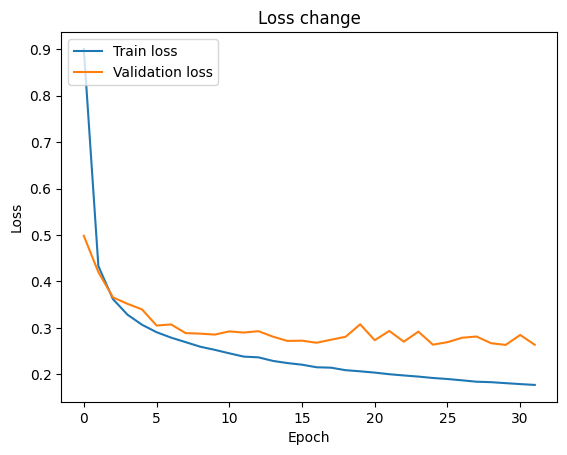

In [14]:
# Visualize loss change

plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Loss change')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

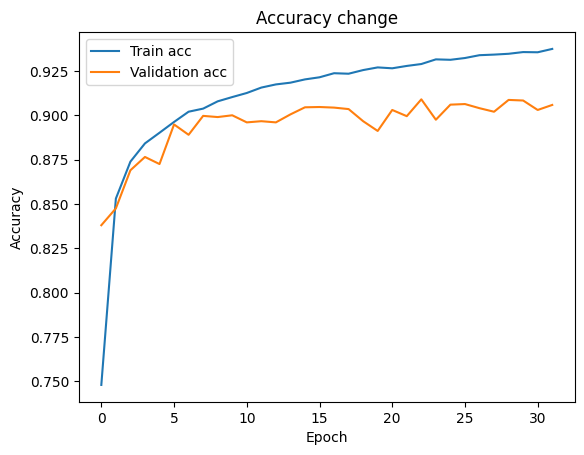

In [15]:
# Visualize accuracy change

plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.title('Accuracy change')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train acc', 'Validation acc'], loc='upper left')
plt.show()

# Testing result & visualization

In [16]:
# Load saved model

testmodel = torch.load('./weights/best.pt')
print("Model is successfully loaded!")

Model is successfully loaded!


<ipython-input-16-3e996cf6f694>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testmodel = torch.load('./weights/best.pt')


Testing...


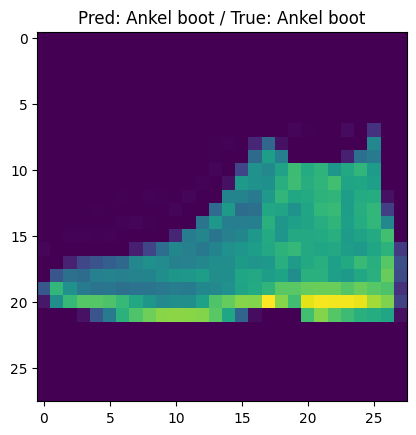

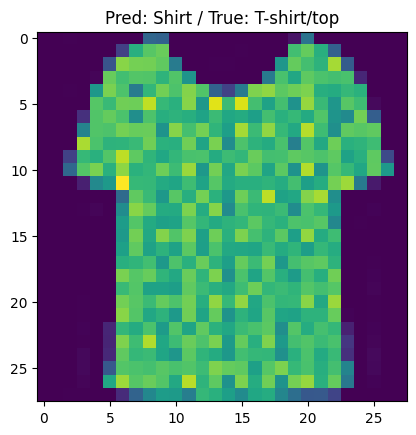

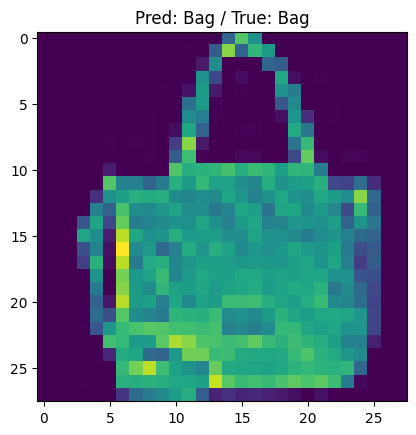

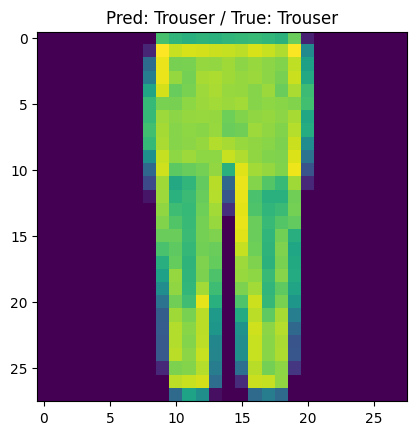

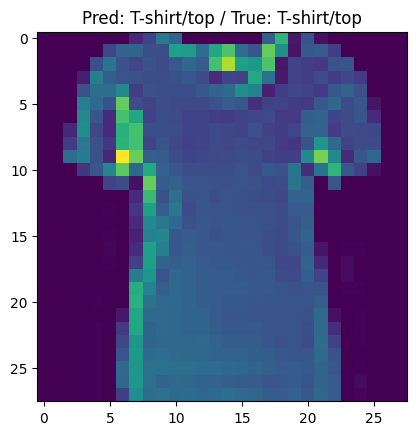

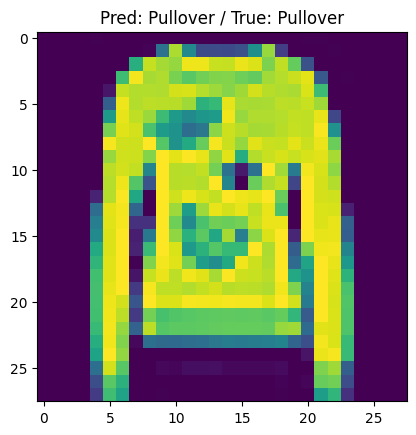

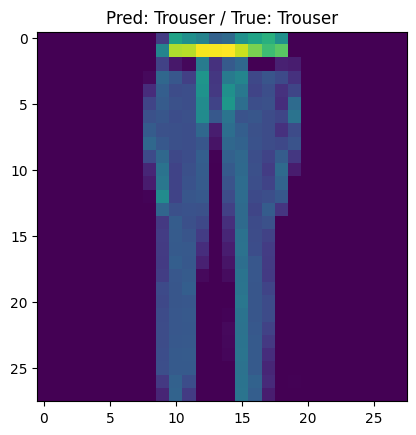

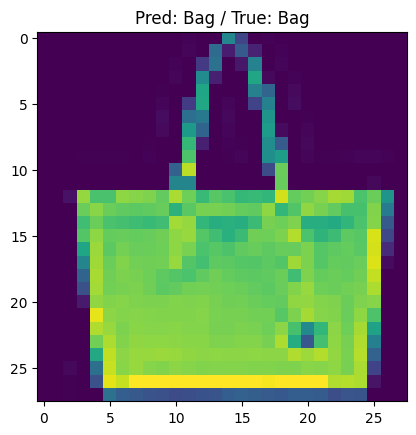

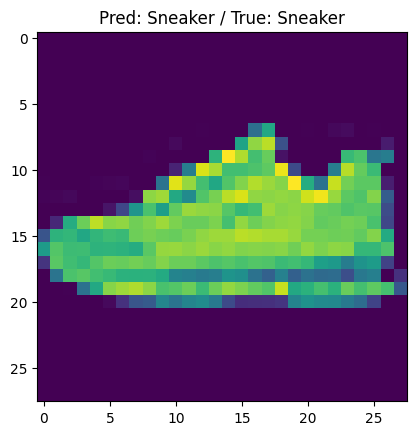

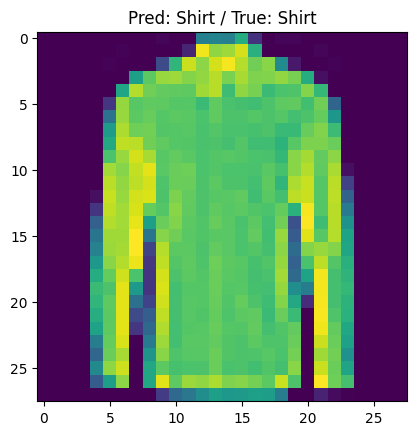


Test accuracy: 0.90


In [17]:
# Checking test accuracy & Visualization

test_correct = 0
test_total = 0
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']

testmodel.eval()
print("Testing...")
with torch.no_grad():
    for idx, i in enumerate(test_loader):
        test_x = i[0].type(torch.float32).to(device) # torch.tensor, [1, 1, 28, 28]
        test_y = i[1].type(torch.int64).to(device) # torch.tensor, [1]

        test_out = testmodel(test_x) # torch.tensor, [10]
        test_pred_y = torch.argmax(test_out, dim=0) # [1]

        test_total += test_y.shape[0]
        for k in range(test_y.shape[0]):
            if torch.equal(test_pred_y, test_y[k]):
                test_correct += 1

        # Visualization of test results
        if idx % 1000 == 0:
          img = test_x.squeeze().detach().cpu().numpy()
          plt.imshow(img)
          plt.title(f"Pred: {classes[test_pred_y.detach().cpu().numpy()]} / True: {classes[test_y.detach().cpu().numpy()[0]]}")
          plt.show()

test_acc = test_correct / test_total
print("\nTest accuracy: %.2f" %(test_acc))